In [11]:
# Import necessary libraries
import re
import string 

import numpy as np
import pandas as pd
import nltk

from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering, KMeans, HDBSCAN
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE

from nltk import word_tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("punkt")

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\petro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\petro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
def load_bbc_dataset(file_path):
    """
    Loads the BBC dataset
    Returns:
    - pd.DataFrame: BBC dataset in DataFrame format.
    """
    try:
        bbc_df = pd.read_csv(file_path)
        return bbc_df
    except FileNotFoundError: 
        print(f"Error: File not found at {file_path}. Exiting program.")
        sys.exit(1)

def load_20newsgroup_dataset():
    """
    Loads the 20 News Group dataset
    Returns:
    - pd.DataFrame: 20 News Group dataset in DataFrame format.
    """
    data_20newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), download_if_missing=True)
    documents_20newsgroups = data_20newsgroups.data
    labels_20newsgroups = data_20newsgroups.target
    labels_names_20newsgroups = data_20newsgroups.target_names
    news_dict = {
        'label': labels_20newsgroups,
        'comment': documents_20newsgroups,
    }
    news_df = pd.DataFrame(news_dict)
    news_df['label_name'] = news_df['label'].apply(lambda x: labels_names_20newsgroups[x])
    _, x_test_news, _, y_test_news = train_test_split(
        news_df,
        news_df['label'],
        test_size=0.1,
        random_state=42,
        stratify=news_df['label']
    )
    return x_test_news

def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens
    Args:
        text: Text to tokenize.
    Returns:
        Tokenized text.
    """
    text = str(text).lower()
    text = re.sub(r"\[(.*?)\]", "", text) # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    tokens = tokenizer(text) # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords] # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens] # Remove digits
    tokens = [t for t in tokens if len(t) > 1] # Remove short tokens
    return tokens

def tf_idf(df):
    """
    Computes the TF-IDF (Term Frequency-Inverse Document Frequency) representation of the given text data.
    Parameters:
    df (pd.Series or list of str): A collection of documents represented as a pandas Series or a list of strings.
    Returns:
    pd.DataFrame: A DataFrame where each row corresponds to a document, and each column represents a term's 
                  TF-IDF score. The columns are the most important 5000 terms selected by the vectorizer.
    """
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df)
    return pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

def fast_text(df, sg_method=0):
    """
    Trains a FastText model on the provided tokenized text data.
    Parameters:
    df (list of list of str): A list where each element is a tokenized document (list of words).
    sg_method (int, optional): Defines the training algorithm. Defaults to 0.
        - `0` (CBOW - Continuous Bag of Words)
        - `1` (Skip-gram)
    Returns:
    gensim.models.FastText: A trained FastText model that can generate word embeddings.
    """
    return FastText(sentences=df, vector_size=100, window=5 , min_count=2, sg=sg_method)

In [25]:
def data_transformation():
    """
    Loads and preprocesses text datasets, applying tokenization, TF-IDF transformation, 
    and word embedding models (Word2Vec & FastText).
    This function performs the following steps:
    1. Loads the BBC News and 20 Newsgroup datasets.
    2. Cleans the text data (tokenization, stopword removal).
    3. Creates a new column for tokenized words and a string version of tokens.
    4. Generates TF-IDF representations for text data.
    5. Trains Word2Vec and FastText models on the tokenized text.
    The results are stored in global variables.
    """

    global bbc_df, newsgroup_df, bbc_df_docs, newsgroup_df_docs, bbc_tfidf, newsgroup_tfidf,  bbc_fastText, newsgroup_fastText
    
    # Loads datasets
    bbc_df = load_bbc_dataset('datasets/bbc_news_test.csv')
    newsgroup_df = load_20newsgroup_dataset()

    label_encoder = LabelEncoder()
    newsgroup_df = newsgroup_df.rename(columns={'comment': 'Text', 'label_name': 'Category'}) # Rename columns for efficiency

    # Encoding Category Columns for future use
    bbc_df["Category_encoded"] = label_encoder.fit_transform(bbc_df["Category"])
    newsgroup_df["Category_encoded"] = label_encoder.fit_transform(newsgroup_df["Category"])

    # List datasets for iteration
    dfs = [bbc_df, newsgroup_df]
    
    for df in dfs:
        # Fill NaN values with empty strings
        df.iloc[:, 1] = df.iloc[:, 1].fillna("")
        
        # Tokenize and clean text (removes stopwords, punctuation, etc.)
        df["tokens"] =df.iloc[:, 1].map(lambda x: clean_text(x, word_tokenize, stopwords.words("english")))
        
        # Convert tokenized words back into a space-separated string
        df["tokens_str"] = df["tokens"].apply(lambda x: " ".join(x))

    # Extract tokenized documents as lists
    bbc_df_docs = bbc_df["tokens"].values
    newsgroup_df_docs = newsgroup_df["tokens"].values
    
    # Compute TF-IDF for processed text
    bbc_tfidf = tf_idf(bbc_df['tokens_str'])
    newsgroup_tfidf = tf_idf(newsgroup_df['tokens_str'])

    # Train FastText embeddings
    bbc_fastText = fast_text(bbc_df_docs)
    newsgroup_fastText = fast_text(newsgroup_df_docs)


In [26]:
def vectorize(list_of_docs, model):
    """
    Create a vector per document by averaging its word vectors to achieve better clustering results
    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding
    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

def kmeans_clustering(data, clusters, method='k-means++', init_num=10, iterations=300):
    """
    Performs KMeans clustering and returns the results.
    Args:
        data : The dataset to apply KMeans on.
        clusters : Number of clusters.
        method : Initialization method ('k-means++' or 'random').
        init_num : Number of initializations.
        iterations : Maximum number of iterations.
    Returns:
        tuple: Labels of the clustering result.
    """
    kmeans = KMeans(
        n_clusters=clusters,
        init=method,
        n_init=init_num,
        max_iter=iterations,
        tol=1e-4,
        random_state=42
    )
    kmeans.fit(data)
    return  kmeans.labels_

def agglomerative_clustering(data, clusters, metric='euclidean', linkage='ward', distance_threshold=None):
    """
    Performs Agglomerative Clustering
    Args:
        data : The dataset to apply AgglomerativeClustering on.
        n_clusters : Number of clusters. Defaults to None.
        metric : Distance metric. Defaults to 'euclidean'.
        linkage : Linkage method. Defaults to 'ward'.
        distance_threshold : Threshold for clustering. Defaults to 0.
        Returns:
        Labels: Labels of the clustering result.
    """
    agg_clustering = AgglomerativeClustering(
        n_clusters=clusters,
        metric=metric,
        linkage=linkage,
        distance_threshold=distance_threshold
    )
    labels = agg_clustering.fit_predict(data)
    return labels

def hdbscan_clustering(data, min_clusters=2, min_samples=4, metric='euclidean'):
    """
    Performs HDBSCAN clustering and returns the clustering labels.
    Args:
        data : The dataset to apply HDBSCAN clustering on.
        min_clusters : Minimum size of clusters. Defaults to 2.
        min_samples : The number of samples in a neighborhood for a point to be considered a core point. Defaults to 4.
        metric : The distance metric to use for clustering. Defaults to 'euclidean'.
    Returns:
        Labels: Labels of the clustering result.
    """
    hdbscan_clustering = HDBSCAN(
        min_cluster_size = min_clusters,
        min_samples = min_samples,
        metric = metric,
        cluster_selection_method = 'eom',
        max_cluster_size = None
    )
    labels = hdbscan_clustering.fit_predict(data)
    return labels

In [27]:
data_transformation()

In [28]:
def vectorize_datasets():
    """
    Vectorize datasets using FastText and TF-IDF models.
    Returns:
        vectorized_models: Dictionary containing vectorized datasets.
    """
    # FastText Models
    bbc_vectorized_ft = vectorize(bbc_df_docs, model=bbc_fastText)
    newsgroup_vectorized_ft = vectorize(newsgroup_df_docs, model=newsgroup_fastText)

    # Store vectorized models for future use
    vectorized_models = {
        "bbc_tfidf": bbc_tfidf,
        "newsgroup_tfidf": newsgroup_tfidf,
        "bbc_fasttext": bbc_vectorized_ft,
        "newsgroup_fasttext": newsgroup_vectorized_ft,
    }

    return vectorized_models

def normalize_datasets(vectorized_models):
    """
    Normalize the vectorized datasets using StandardScaler.
    Args:
        vectorized_models: Dictionary containing vectorized datasets.
    Returns:
        normalized_data: Dictionary containing normalized datasets.
    """
    normalized_data = {}
    scaler = StandardScaler()

    for name, data in vectorized_models.items():
        normalized_data[f"{name}_normalized"] = scaler.fit_transform(data)

    return normalized_data

def apply_clustering(datasets):
    """
    Apply K-Means, Agglomerative, and HDBSCAN clustering.
    Args:
        datasets: Dictionary containing datasets.
    Returns:
        clustering_results: Dictionary containing clustering labels.
    """
    # Dictionary to store clustering results
    clustering_results = {}

    for name, data in datasets.items():
        print(f"Running clustering for {name}...")

        # K-Means Clustering
        kmeans_labels = kmeans_clustering(data=data, clusters=5 if "bbc" in name else 20)
        clustering_results[f"{name}_kmeans"] = kmeans_labels

        # Agglomerative Clustering
        agg_labels = agglomerative_clustering(data=data, clusters=5 if "bbc" in name else 20)
        clustering_results[f"{name}_agg"] = agg_labels

        # HDBSCAN Clustering
        hdbscan_labels = hdbscan_clustering(data=data, min_clusters=10 if "bbc" in name else 30)
        clustering_results[f"{name}_hdbscan"] = hdbscan_labels

    return clustering_results

def evaluate_clustering_results(true_labels, clustering_results):
    """
    Evaluates clustering performance using NMI, ARI, and AMI.
    Args:
        true_labels: The ground-truth labels.
        predicted_labels: The clustering labels.
    Returns:
        dict: Scores for NMI, ARI, and AMI.
    """
    evaluation_scores = {}
    for key, predicted_label in clustering_results.items():
        dataset_name = key.split('_')[0]  # Extract dataset name

        if dataset_name in true_labels:
            y_true = true_labels[dataset_name]
            
            # Compute evaluation metrics
            nmi = normalized_mutual_info_score(y_true, predicted_label)
            ari = adjusted_rand_score(y_true, predicted_label)
            ami = adjusted_mutual_info_score(y_true, predicted_label)

            # Store results
            evaluation_scores[key] = {"NMI": nmi, "ARI": ari, "AMI": ami}

    return evaluation_scores 

def clustering_evaluation(clusterResults): 
    true_labels = {
        "bbc": bbc_df["Category_encoded"].values,
        "newsgroup": newsgroup_df["Category_encoded"].values
    }
    
    return evaluate_clustering_results(true_labels, clusterResults)

In [29]:
# Perform clustering algorithms with normalized and non normalized data to experiment
vectorized_models = vectorize_datasets()
# Normalize the data
normalized_data = normalize_datasets(vectorized_models)
# Clustering with normalized data
clustering_results = apply_clustering(normalized_data)

Running clustering for bbc_tfidf_normalized...
Running clustering for newsgroup_tfidf_normalized...
Running clustering for bbc_fasttext_normalized...
Running clustering for newsgroup_fasttext_normalized...


In [30]:
# Evaluate clustering results for normalized data
clustering_scores = clustering_evaluation(clustering_results)
clustering_scores

{'bbc_tfidf_normalized_kmeans': {'NMI': 0.2862578564534418,
  'ARI': 0.07908004656792843,
  'AMI': 0.2825202400271473},
 'bbc_tfidf_normalized_agg': {'NMI': 0.6596826581736153,
  'ARI': 0.614191869583745,
  'AMI': 0.658506309787198},
 'bbc_tfidf_normalized_hdbscan': {'NMI': 0.0, 'ARI': 0.0, 'AMI': 0.0},
 'newsgroup_tfidf_normalized_kmeans': {'NMI': 0.020651992782552954,
  'ARI': 1.0312349062378539e-05,
  'AMI': 0.00047924446011771637},
 'newsgroup_tfidf_normalized_agg': {'NMI': 0.05450384564671319,
  'ARI': 0.0011816635163185707,
  'AMI': 0.0305536803140322},
 'newsgroup_tfidf_normalized_hdbscan': {'NMI': 0.0, 'ARI': 0.0, 'AMI': 0.0},
 'bbc_fasttext_normalized_kmeans': {'NMI': 0.3426604477926779,
  'ARI': 0.27282585860923786,
  'AMI': 0.3404223394160218},
 'bbc_fasttext_normalized_agg': {'NMI': 0.34771528570425997,
  'ARI': 0.25385142006283523,
  'AMI': 0.3454537807394354},
 'bbc_fasttext_normalized_hdbscan': {'NMI': 0.021521116169052553,
  'ARI': 0.010109007196572642,
  'AMI': 0.01910

In [31]:
# Clustering with non normalized data
clustering_results_non_normalized = apply_clustering(vectorized_models)

Running clustering for bbc_tfidf...
Running clustering for newsgroup_tfidf...
Running clustering for bbc_fasttext...
Running clustering for newsgroup_fasttext...


In [32]:
# Evaluate clustering results for non normalized data
non_normalized_clustering_scores = clustering_evaluation(clustering_results_non_normalized)
non_normalized_clustering_scores

{'bbc_tfidf_kmeans': {'NMI': 0.6988246983591758,
  'ARI': 0.610916104508112,
  'AMI': 0.6977755161825929},
 'bbc_tfidf_agg': {'NMI': 0.6226064736261523,
  'ARI': 0.5524590392891742,
  'AMI': 0.6212915758973312},
 'bbc_tfidf_hdbscan': {'NMI': 0.33948592790357507,
  'ARI': 0.04005309500325106,
  'AMI': 0.32669861697956853},
 'newsgroup_tfidf_kmeans': {'NMI': 0.02585973359704961,
  'ARI': 7.37394064493125e-05,
  'AMI': 0.003405423735693078},
 'newsgroup_tfidf_agg': {'NMI': 0.28637800073529635,
  'ARI': 0.0495572258813548,
  'AMI': 0.2565953814480956},
 'newsgroup_tfidf_hdbscan': {'NMI': 0.0, 'ARI': 0.0, 'AMI': 0.0},
 'bbc_fasttext_kmeans': {'NMI': 0.29594423887008214,
  'ARI': 0.201501061530305,
  'AMI': 0.29353800192725243},
 'bbc_fasttext_agg': {'NMI': 0.28409708450695936,
  'ARI': 0.15651206779972712,
  'AMI': 0.28146622211529304},
 'bbc_fasttext_hdbscan': {'NMI': 0.05425372002736521,
  'ARI': 0.019111067845791474,
  'AMI': 0.052101858703688816},
 'newsgroup_fasttext_kmeans': {'NMI': 0

In [33]:
def apply_pca(embeddings, n_components, dataset_name, labels):
    """
    Apply PCA to the embeddings and visualize the reduced data using t-SNE.
    Args:
        embeddings : The input embeddings for dimensionality reduction.
        n_components : Number of components to retain for PCA.
        dataset_name : Name of the dataset (used in visualizations).
        labels: Ground truth labels for the dataset.
    
    Returns:
        reduced_embeddings: PCA-reduced embeddings.
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    print(f"The sum of the explained variance of those components is {pca.explained_variance_ratio_.sum()}")

    # Visualize using t-SNE
    tsne_visualization(reduced_embeddings, dataset_name, labels)
    return reduced_embeddings

def tsne_visualization(dataset, dataset_name, labels):
    """
    Apply t-SNE to the dataset and visualize the results.
    Args:
        dataset: The input data (e.g., PCA-reduced embeddings).
        dataset_name : Name of the dataset (for visualization purposes).
        labels : Ground truth labels for coloring the t-SNE plot.
    """
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    dataset_tsne = tsne.fit_transform(dataset)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=dataset_tsne[:, 0], y=dataset_tsne[:, 1], hue=labels, palette="deep", alpha=0.7)
    plt.title(f"t-SNE Visualization of {dataset_name}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Categories")
    plt.show()

The sum of the explained variance of those components is 0.12709987550357088


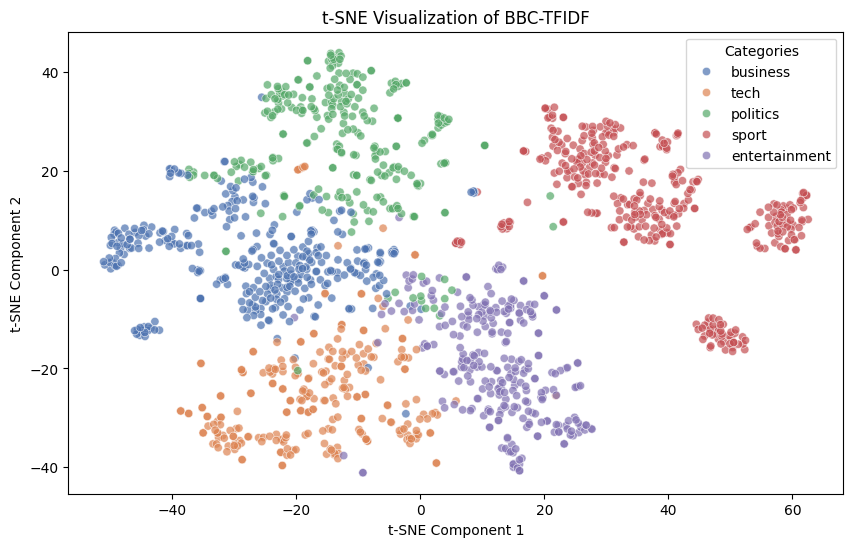

The sum of the explained variance of those components is 0.9986867146729723


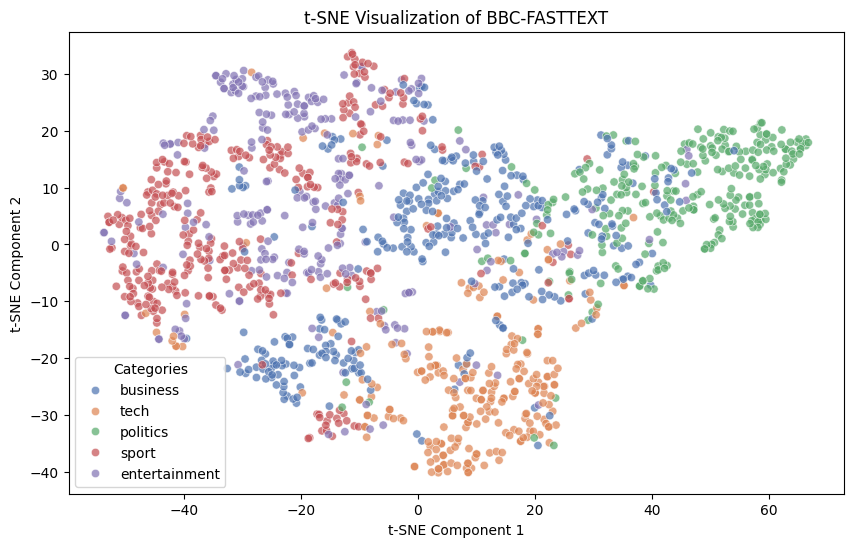

In [34]:
# For BBC Dataset
bbc_tfidf_pca = apply_pca(embeddings=normalized_data['bbc_tfidf_normalized'], n_components=50, dataset_name='BBC-TFIDF', labels=bbc_df['Category'])
bbc_fasttext_pca = apply_pca(embeddings=normalized_data['bbc_fasttext_normalized'], n_components=10, dataset_name='BBC-FASTTEXT', labels=bbc_df['Category'])

The sum of the explained variance of those components is 0.1094279527133032


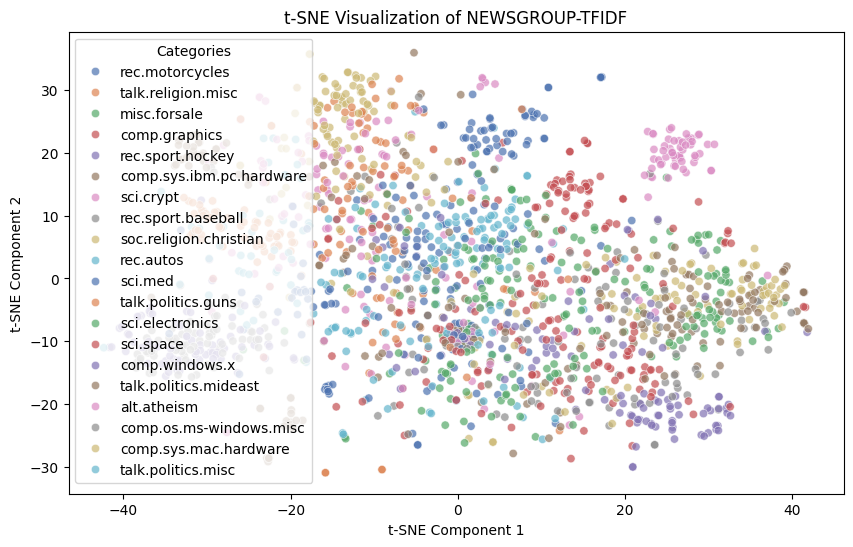

The sum of the explained variance of those components is 0.9999110489722941


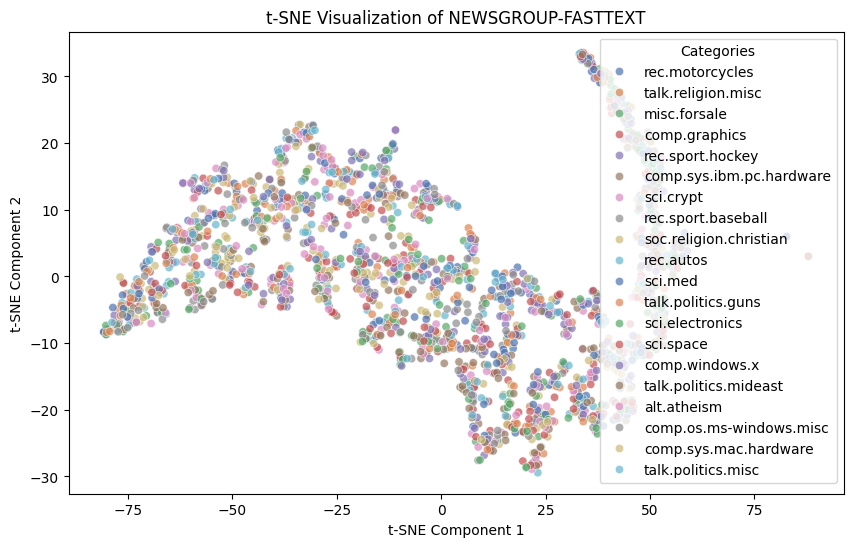

In [35]:
# For Newsgroup Dataset
newsgroup_tfidf_pca = apply_pca(embeddings=normalized_data['newsgroup_tfidf_normalized'], n_components=50, dataset_name='NEWSGROUP-TFIDF', labels=newsgroup_df['Category'])
newsgroup_fasttext_pca = apply_pca(embeddings=normalized_data['newsgroup_fasttext_normalized'], n_components=20, dataset_name='NEWSGROUP-FASTTEXT', labels=newsgroup_df['Category'])

For both datasets, FastText embeddings retain almost all variance during PCA, while TFIDF embeddings retain significantly less variance. FastText appears to perform better for the Newsgroup dataset, showing better-defined clusters compared to TFIDF, which struggles with sparsity and overlapping clusters. However, for the BBC dataset, TFIDF seems to handle the simpler structure better, with less overlap compared to FastText.

In [36]:
def visualization(df_results, type_of_data):
    """
    Visualize the clustering results using bar plots for NMI, ARI, and AMI metrics.
    Args:
        df_results: A DataFrame containing clustering results with columns:
                                   - "Dataset": Name of the dataset.
                                   - "Method": Clustering method.
                                   - "NMI": Normalized Mutual Information scores.
                                   - "ARI": Adjusted Rand Index scores.
                                   - "AMI": Adjusted Mutual Information scores.
    """
    metrics = ["NMI", "ARI", "AMI"]
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=df_results,
            x="Method",
            y=metric,
            hue="Dataset",
            palette="Set2",
        )
        plt.title(f"Comparison of {metric} Across Methods and Datasets - {type_of_data}")
        plt.xlabel("Clustering Method")
        plt.ylabel(metric)
        plt.legend(title="Dataset")
        plt.show()

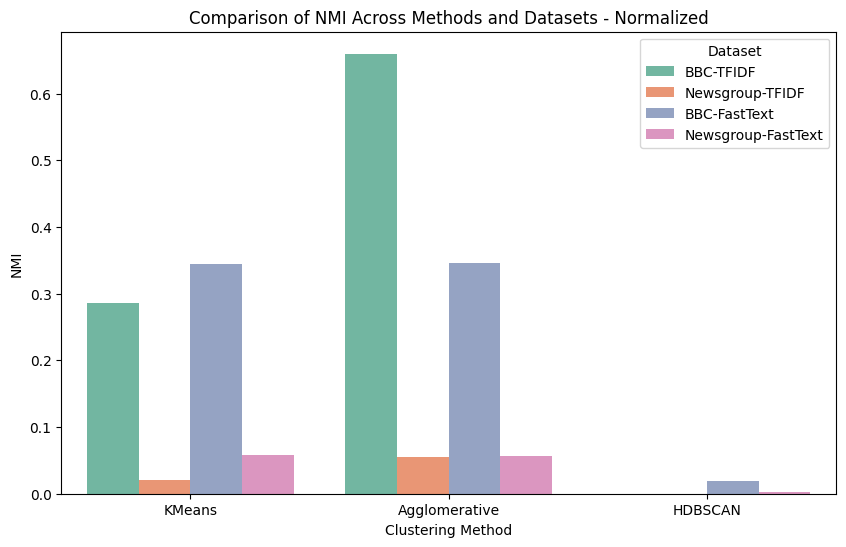

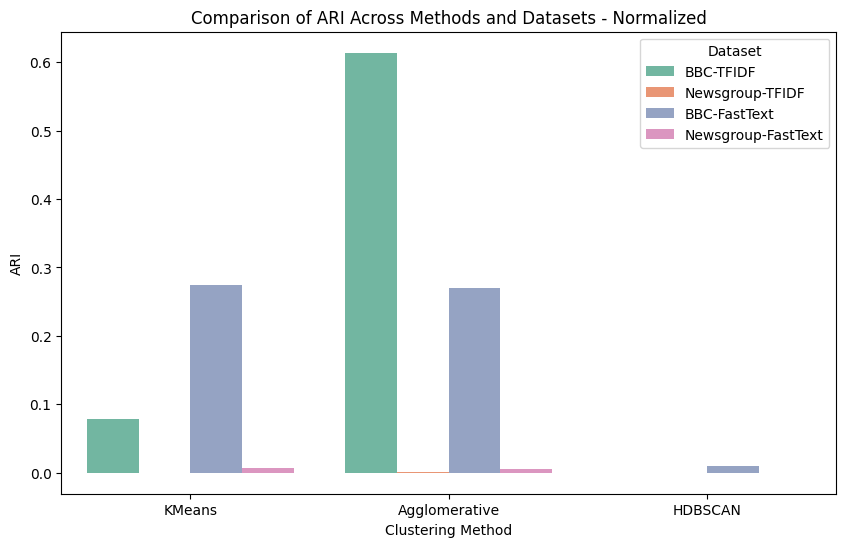

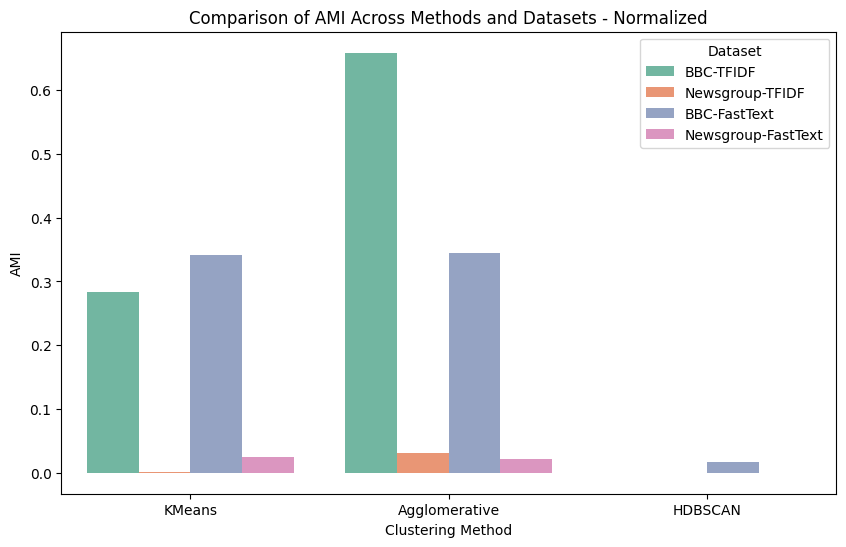

In [37]:
clustering_results_normalized = {
    "Dataset": [
        "BBC-TFIDF", "BBC-TFIDF", "BBC-TFIDF",
        "Newsgroup-TFIDF", "Newsgroup-TFIDF", "Newsgroup-TFIDF",
        "BBC-FastText", "BBC-FastText", "BBC-FastText",
        "Newsgroup-FastText", "Newsgroup-FastText", "Newsgroup-FastText"
    ],
    "Method": [
        "KMeans", "Agglomerative", "HDBSCAN",
        "KMeans", "Agglomerative", "HDBSCAN",
        "KMeans", "Agglomerative", "HDBSCAN",
        "KMeans", "Agglomerative", "HDBSCAN"
    ],
    "NMI": [
        0.286, 0.660, 0.000,
        0.021, 0.055, 0.000,
        0.344, 0.346, 0.019,
        0.058, 0.056, 0.003
    ],
    "ARI": [
        0.079, 0.614, 0.000,
        0.000, 0.001, 0.000,
        0.274, 0.270, 0.009,
        0.007, 0.006, -0.0001
    ],
    "AMI": [
        0.283, 0.659, 0.000,
        0.001, 0.031, 0.000,
        0.342, 0.344, 0.017,
        0.025, 0.021, -0.0001
    ]
}

df_normalized = pd.DataFrame(clustering_results_normalized)
visualization(df_normalized, 'Normalized')

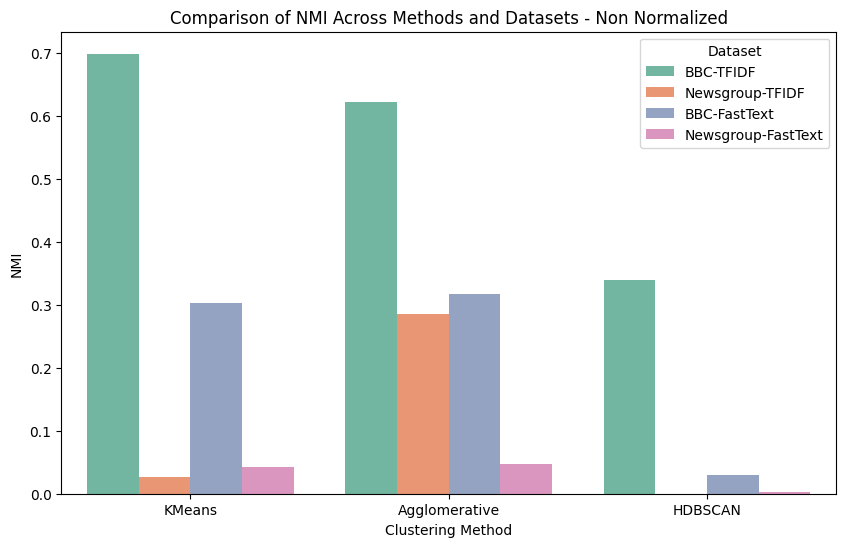

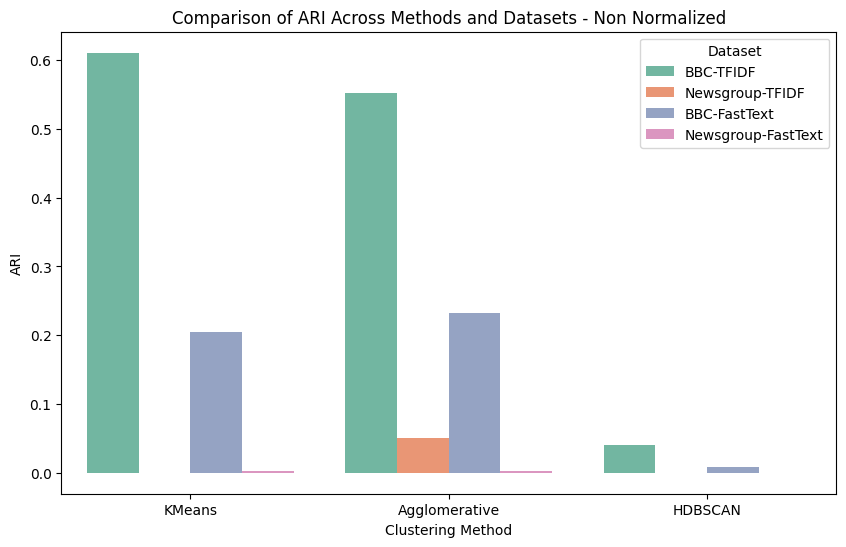

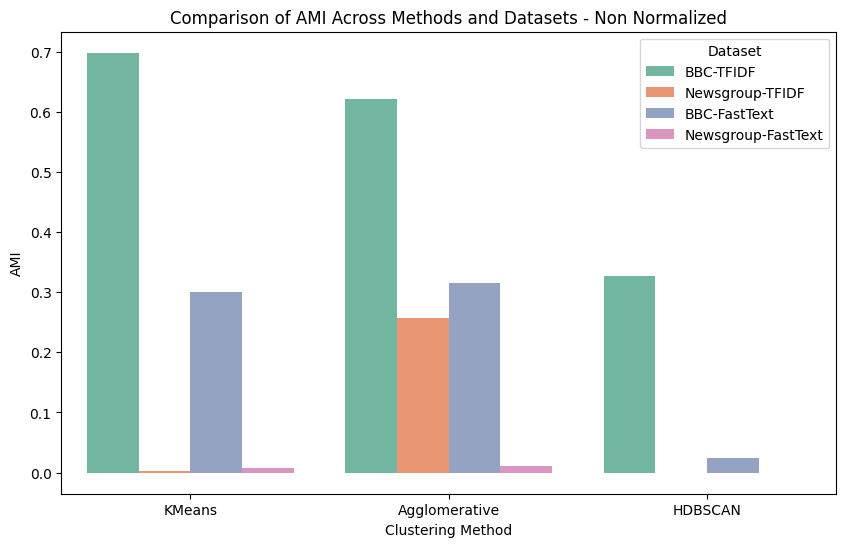

In [38]:
clustering_results_non_normalized = {
    "Dataset": [
        "BBC-TFIDF", "BBC-TFIDF", "BBC-TFIDF",
        "Newsgroup-TFIDF", "Newsgroup-TFIDF", "Newsgroup-TFIDF",
        "BBC-FastText", "BBC-FastText", "BBC-FastText",
        "Newsgroup-FastText", "Newsgroup-FastText", "Newsgroup-FastText"
    ],
    "Method": [
        "KMeans", "Agglomerative", "HDBSCAN",
        "KMeans", "Agglomerative", "HDBSCAN",
        "KMeans", "Agglomerative", "HDBSCAN",
        "KMeans", "Agglomerative", "HDBSCAN"
    ],
    "NMI": [
        0.699, 0.623, 0.339,
        0.026, 0.286, 0.000,
        0.303, 0.318, 0.029,
        0.043, 0.047, 0.003
    ],
    "ARI": [
        0.611, 0.552, 0.040,
        0.0001, 0.050, 0.000,
        0.205, 0.233, 0.008,
        0.002, 0.003, -0.0001
    ],
    "AMI": [
        0.698, 0.621, 0.327,
        0.003, 0.257, 0.000,
        0.301, 0.316, 0.025,
        0.008, 0.011, -0.0001
    ]
}

df_non_normalized = pd.DataFrame(clustering_results_non_normalized)
visualization(df_non_normalized, 'Non Normalized')

HDBSCAN struggles with both normalized and non-normalized data, showing only slight improvement with non-normalized data for the BBC-TFIDF dataset.
Agglomerative clustering performs better with non-normalized data, particularly for the simpler BBC dataset, where the improvement is more pronounced compared to the more complex Newsgroup dataset.
K-Means also demonstrates slightly better performance with non-normalized data, especially for the BBC dataset.
Overall, the BBC dataset consistently achieves better metrics due to its fewer categories which make clustering algorithms to identify patterns, whereas the more complex Newsgroup dataset only outperforms in certain cases, such as with Agglomerative clustering.